In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import glob
import json
import torch
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO
import cv2
import segmentation_models_pytorch as smp

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
yolo_model = YOLO('/workspace/jay/DDP/Ocelot/submission/ocelot23algo/yolov8.pt')
device = 'cuda:1'

# model = smp.DeepLabV3Plus(
#     encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_depth=5,
#     encoder_weights='imagenet',     # use `imagenet` pre-trained weights for encoder initialization
#     activation=None,
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=3,                      # model output channels (number of classes in your dataset)
# )

tissue_seg_model = torch.load('/workspace/jay/DDP/Ocelot/tissue_seg/deeplab_ckpts/113_0.33791.pt' , map_location=device)
#model.load_state_dict(torch.load('/workspace/jay/DDP/Ocelot/tissue_seg/sub_ckpts/41_0.080.pt' , map_location=device))
tissue_seg_model = tissue_seg_model.to(device)
tissue_seg_model.eval()
model = torch.load('/workspace/jay/DDP/Ocelot/celltissue/deeplab_dice_ckpts/147_0.28835.pt')
model = model.to(device)
model = model.eval()
#temp = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/test/images/*.jpg')

In [3]:
val = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/valid/images/*.jpg')
test = glob.glob('/workspace/jay/DDP/Ocelot/yolo_binary/datasets/cell_detect_33-1/test/images/*.jpg')
train = sorted(glob.glob('/workspace/jay/DDP/Ocelot/ocelot2023/images/train/cell/*.jpg'))
val_files = np.unique(np.array([x.split('/')[-1][:3] for x in val]))
test_files = np.unique(np.array([x.split('/')[-1][:3] for x in test]))
train_files = np.unique(np.array([x.split('/')[-1][:3] for x in train]))

In [4]:
pred_json = {
    "type": "Multiple points",
    "num_images": len(train_files),
    "points": [],
    "version": {
        "major": 1,
        "minor": 0,
    }
}

In [5]:
cell_files = sorted([f'/workspace/jay/DDP/Ocelot/ocelot2023/images/train/cell/{idx}.jpg' for idx in val_files])
tissue_files = sorted([f'/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/{idx}.jpg' for idx in val_files])
cell_csvs = sorted([f'/workspace/jay/DDP/Ocelot/ocelot2023/annotations/train/cell/{idx}.csv' for idx in val_files])
tissue_masks = sorted([f'/workspace/jay/DDP/Ocelot/ocelot2023/annotations/train/tissue/{idx}.png' for idx in val_files])
with open('/workspace/jay/DDP/Ocelot/ocelot2023/metadata.json') as f:
    jsonn = json.load(f)
softmax = torch.nn.Softmax(dim=1)

In [6]:
for j,file in enumerate(tqdm(val_files)):
    idx = int(file) -1 
    cell_path = f'/workspace/jay/DDP/Ocelot/ocelot2023/images/train/cell/{file}.jpg'
    tissue_path = f'/workspace/jay/DDP/Ocelot/ocelot2023/images/train/tissue/{file}.jpg'
    cell = (np.array(Image.open(cell_path))/255) - 0.5
    cell = torch.Tensor(np.moveaxis(cell, -1, 0))
    cell = cell[None,:]
    cell = cell.to(device)  
    tissue = (np.array(Image.open(tissue_path))/255) - 0.5
    tissue = torch.Tensor(np.moveaxis(tissue, -1, 0))
    tissue = tissue[None,:]
    tissue = tissue.to(device)   
    with torch.no_grad():
        tissue_out = softmax(tissue_seg_model(tissue))
    image = torch.zeros((1,6,1024,1024)).to(device)
    for i in range(1):
        yc = int(jsonn['sample_pairs'][file]['patch_x_offset']*1024)
        xc = int(jsonn['sample_pairs'][file]['patch_y_offset']*1024)
        tissue_crop = np.moveaxis(tissue_out[i].cpu().numpy(),0,-1)
        tissue_crop = tissue_crop[xc-128:xc+128,yc-128:yc+128,:]
        tissue_crop = cv2.resize(tissue_crop, dsize=(1024,1024), interpolation = cv2.INTER_NEAREST)   
        tissue_crop = torch.Tensor(np.moveaxis(tissue_crop,-1,0))
        image[i] = torch.concat((cell[i],tissue_crop.to(device)),dim=0)
    with torch.no_grad():
        output = softmax(model(image))
    output = np.moveaxis(output.cpu().numpy()[0],0,-1)
    
    out = yolo_model.predict(cell_path,conf=0.2,iou=0.5)
    out = out[0].cpu().numpy()
    boxes = out.boxes.data
    
    for i in range(len(boxes)):
        x,y = min(1023,int((boxes[i][0]+boxes[i][2])/2)), min(1023,int((boxes[i][1]+boxes[i][3])/2))
        yprob = boxes[i][4]
        yclas = boxes[i][5]
        tclas = int(np.argmax(output[y,x,:]))
        tprob = output[y,x,tclas]
        if yprob>tprob:
            prob=yprob
            clas = yclas
        else:
            prob=tprob
            clas=tclas
        if clas==2:
            clas = int(np.argmax(output[y,x,:2]))
            point = {
                    "name": f"image_{idx}",
                    "point": [int(x), int(y), int(clas)+1],
                    "probability": output[y,x,clas].astype(float),  # dummy value, since it is a GT, not a prediction
                    }
            pred_json["points"].append(point)
        else:
            point = {
                    "name": f"image_{idx}",
                    "point": [int(x), int(y), int(clas)+1],
                    "probability": prob.astype(float),  # dummy value, since it is a GT, not a prediction
                    }
            pred_json["points"].append(point)
                                

  0%|                                                                                                                                                                               | 0/40 [00:00<?, ?it/s]Ultralytics YOLOv8.0.20 🚀 Python-3.8.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-80GB, 81251MiB)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.87it/s]


In [7]:
# with open("/workspace/jay/DDP/Ocelot/jsons/pred1.json", "w") as g:
with open("/workspace/jay/DDP/Ocelot/ocelot23algo/evaluation/yolo_celltissue_val.json", "w") as g:
    json.dump(pred_json, g)
    print("JSON file saved")

JSON file saved


In [5]:
for j,file in enumerate(tqdm(test_files)):
    idx = int(file) -1 
    path = f'/workspace/jay/DDP/Ocelot/ocelot2023/images/train/cell/{file}.jpg'
    img = np.array(Image.open(path))
    out = model.predict(path,conf=0.2,iou=0.5)
    out = out[0].cpu().numpy()
    boxes = out.boxes.data
    
    for i in range(len(boxes)):
        x,y = min(1023,int((boxes[i][0]+boxes[i][2])/2)), min(1023,int((boxes[i][1]+boxes[i][3])/2))
        prob = boxes[i][4]
        clas = boxes[i][5]
        point = {
                "name": f"image_{idx}",
                "point": [int(x), int(y), int(clas)+1],
                "probability": prob.astype(float),  # dummy value, since it is a GT, not a prediction
                }
        pred_json["points"].append(point)
                                


  0%|                                                                                                                                                                               | 0/40 [00:00<?, ?it/s]Ultralytics YOLOv8.0.20 🚀 Python-3.8.13 torch-1.13.1+cu117 CUDA:0 (NVIDIA A100-SXM4-80GB, 81251MiB)
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  8.80it/s]


In [7]:
# with open("/workspace/jay/DDP/Ocelot/jsons/pred1.json", "w") as g:
with open("/workspace/jay/DDP/Ocelot/ocelot23algo/evaluation/yolo_pred_binary_test.json", "w") as g:
    json.dump(pred_json, g)
    print("JSON file saved")

JSON file saved


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/opt/conda/lib/python3.8/site-packages/urllib3/util/connection.py", line 95, in create_connection
    raise err
  File "/opt/conda/lib/python3.8/site-packages/urllib3/util/connection.py", line 85, in create_connection
    sock.connect(sa)
TimeoutError: [Errno 110] Connection timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py", line 386, in _make_request
    self._validate_conn(conn)
  File "/opt/conda/lib/python3.8/site-packages/urllib3/connectionpool.py", line 1042, in _validate_conn
    conn.connect()
  File 

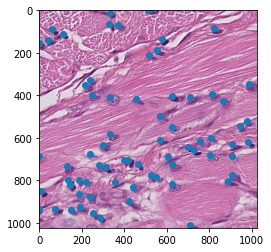

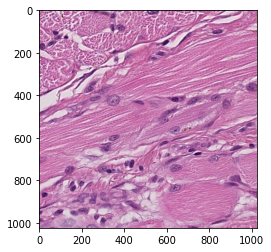

In [6]:
coords = boxes[:,:2]
plt.figure()
plt.imshow(img)
plt.scatter(coords[:,0],coords[:,1])
plt.figure()
plt.imshow(img)

100%|██████████████████████████████████████████████████████████████| 400/400 [00:49<00:00,  8.11it/s]


JSON file saved


In [9]:
len(pred_json['points'])

57392